In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle

from bs4 import BeautifulSoup

# import
import keras
import tensorflow as tf
import numpy as np
import keras.backend as K
from keras.utils import to_categorical
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split

# set seeds
import random
from numpy.random import seed
seed(2)

In [2]:
from google.colab import drive
data_path = f'/content/drive'
drive.mount(data_path, force_remount=True)

Mounted at /content/drive


In [3]:
print(data_path)
os.path.exists(data_path)

/content/drive


True

In [4]:
dir_list = os.listdir(f'{data_path}')
dir_list

['MyDrive',
 '.shortcut-targets-by-id',
 '.file-revisions-by-id',
 'Shareddrives',
 '.Trash-0']

In [5]:
data_path = f'{data_path}/MyDrive/phish_data'
data_path

'/content/drive/MyDrive/phish_data'

In [6]:
dir_list = os.listdir(f'{data_path}')
dir_list

['.ipynb_checkpoints',
 'processed',
 'all_setlist.pkl',
 'all_setlists_after99.pkl',
 'logs4_take1',
 'logs4',
 'reporting']

In [7]:
os.path.exists(f'{data_path}/all_setlist.pkl')


True

In [8]:
os.path.exists('/content/drive/MyDrive/phish_data/all_setlist.pkl')

True

In [34]:
## Test Load --
# file_path = f'{data_path}/processed/mvp-setlist-modeling1/seqlen-150/X_train.pkl'
# test_load_in = open(file_path, 'rb')
# pickle_obj = pickle.load(test_load_in)
# print(type(pickle_obj), pickle_obj)

## Util Methods
### Data Processing and Loading.

In [9]:
### Code from Util.py

'''
Utility functions for the phish-setlist-modeling package

'''

# ------------------------- General Utilities -------------------------

def create_pickle_object(obj, pickle_name, file_path='./pkl_objects/'):
    """Pickle a Python object and save to local directory

    Parameters
    ----------
    obj : Python object
        The Python object to pickle
    pickle_name : string
        The file name of that will be saved with the file; must end with '.pkl' suffix
    file_path : string
        The path (absolute or relative) to the target directory where the pickle file will be stored
    """

    # validate datatypes
    if isinstance(pickle_name, str) and isinstance(file_path, str):

        # verify .pickle suffix
        if pickle_name[-4:] != '.pkl':
            raise ValueError('The pickle_name argument must end with a .pkl suffix.')

        # build full path
        full_path = file_path + pickle_name
    else:
        raise ValueError('Both file_name and file_path arguments must be of type string.')

    # check if directory exists - create if it doesnt
    if not os.path.exists(file_path):
        os.makedirs(file_path)

    # open new file and dump serialized data
    pickle_out = open(full_path, 'wb')
    pickle.dump(obj, pickle_out)
    pickle_out.close()

    print(f'Successfully pickled {pickle_name} to {os.path.abspath(full_path)}')

    return None

def load_pickle_object(file_path):
    """Load a pickled Python object from local directory

    Parameters
    ----------
    file_path : string
        The path (absolute or relative) to the target directory where the pickle file is stored

    Returns
    -------
    pickle_obj : Python object
        The Python object from stored serialized representation
    """

    # check if file_path is string
    if not isinstance(file_path, str):
        raise TypeError('The file_path argument must be a string.')

    # check if the file exists
    if not os.path.exists(file_path):
        raise NameError('The file or path provided does not exist.')

    # verify .pickle file as target
    if not (file_path[-7:] == '.pickle' or file_path[-4:] == '.pkl'):
        raise ValueError('The file must end with a .pickle or .pkl suffix.')

    pickle_in = open(file_path, 'rb')
    pickle_obj = pickle.load(pickle_in)
    #pickle_obj = np.load(file_path, allow_pickle = True)

    return pickle_obj

def parse_setlist_field(html_response_string):
    """Parse the HTML response of a "setlist" field from the get_setlist() API wrapper

    Parameters
    ----------
    html_response_string : str
        The value stored in the "setlist" field from the get_setlist() API wrapper

    Returns
    -------
    full_setlist : str
        The show setlist as a string with songs/set identifiers separated by commas

    Example
    -------

    Input:
    '<p><span class=\'set-label\'>Set 1</span>: <a href=\'http://phish.net/song/you-enjoy-myself\' class=\'setlist-song\'>You Enjoy Myself</a>, <a href=\'http://phish.net/song/turtle-in-the-clouds\' class=\'setlist-song\'>Turtle in the Clouds</a>, <a href=\'http://phish.net/song/46-days\' class=\'setlist-song\'>46 Days</a>, <a href=\'http://phish.net/song/no-men-in-no-mans-land\' class=\'setlist-song\'>No Men In No Man\'s Land</a> > <a href=\'http://phish.net/song/emotional-rescue\' class=\'setlist-song\'>Emotional Rescue</a>, <a title="A quality jam with an uncommonly subdued tone seems to momentarily wind down at 5:15 before launching into another round of synth-groove and builds to a rocking finale capped by strong Trey leads. " href=\'http://phish.net/song/tube\' class=\'setlist-song\'>Tube</a> > <a href=\'http://phish.net/song/shade\' class=\'setlist-song\'>Shade</a>, <a href=\'http://phish.net/song/saw-it-again\' class=\'setlist-song\'>Saw It Again</a></p><p><span class=\'set-label\'>Set 2</span>: <a title="Massive Set 2 opener. Pivots into a gritty and nasty jam at Mike\'s urging, which gets very heavy (and a tad flubby) as Trey takes control. A gnarled groove emerges, with Page laying on the electric piano extra thick, and then Trey pivots into major-key territory. The jam grows warm and pleasant as Mike moves into the lead, Page throwing in a carnivalesque ambiance, then Trey starts firing off some crunchy solos and we enter the wonderful land of hard rocking. A few &quot;woos&quot; are goosed, then Page hits on some ascending not unlike &quot;Tweezer Reprise&quot; and the jam peaks in wonderful fashion. > into an equally outstanding &quot;Mercury&quot;." href=\'http://phish.net/song/set-your-soul-free\' class=\'setlist-song\'>Set Your Soul Free</a> > <a title="Great Version. > from a huge &quot;SYSF,&quot; play breaks free around 10:00, Trey\'s tone warm, rife with melody, floating atop waves of Page\'s now signature keys. With a series of licks Trey pushes play forward, the jam builds in energy, before a huge blast of sustain peels apart (with Page now on his piano) into one of &quot;Mercury\'s&quot; finer moments. Play rocks, with the band alighting upon a sudden, and infectious groove. Pretty cool. > &quot;Slave.&quot;    " href=\'http://phish.net/song/mercury\' class=\'setlist-song\'>Mercury</a> > <a href=\'http://phish.net/song/slave-to-the-traffic-light\' class=\'setlist-song\'>Slave to the Traffic Light</a> > <a href=\'http://phish.net/song/possum\' class=\'setlist-song\'>Possum</a> > <a href=\'http://phish.net/song/sanity\' class=\'setlist-song\'>Sanity</a> > <a href=\'http://phish.net/song/walk-away\' class=\'setlist-song\'>Walk Away</a></p><p><span class=\'set-label\'>Encore</span>: <a href=\'http://phish.net/song/more\' class=\'setlist-song\'>More</a>'

    Output:
    "Set 1, You Enjoy Myself, Turtle in the Clouds, 46 Days, No Men In No Man's Land, Emotional Rescue, Tube, Shade, Saw It Again, Set 2, Set Your Soul Free, Mercury, Slave to the Traffic Light, Possum, Sanity, Walk Away, Encore, More"

    """

    soup = BeautifulSoup(html_response_string, 'html.parser')

    # initialize list to collect songs
    full_setlist = []

    # loop through <p> tags to extract songs from each set (a <p> tag for each set)
    for set_ in list(soup.children):

        # verify the set is populated, if its unknown, skip it
        if str(set_) == '<i>Setlist unknown</i>':
            pass

        else:
            # verify only one set identifier per <p> tag
            if len(set_.find_all('span')) > 1:

                raise ValueError('Set data contains more than on span tag (i.e. set identifier). Need to investigate.')

            # extract set identifier (i.e. Set 1, Set 2, Set 3, Encore)
            set_identifier = set_.find_all('span')[0].get_text()

            # extract list of songs in order
            setlist = [song.get_text() for song in set_.find_all('a')]

            # combine
            combined_set = [set_identifier] + setlist

            full_setlist.extend(combined_set)

    return ', '.join(full_setlist)

## Model Code

In [15]:
### Code from model.py

def load_training_data(seq_len):
    '''
    Loads in all data needed for training a setlist prediction model.

    NOTE - Assumes all training data has be build using make_dataset.py located in src/scripts.

    Args:
        seq_len (int) - sequence length used to build the dataset in make_datset.py, used for folder routing
    Returns:
        X_train (ndarray) - 2D array representing X training data of shape = number of sequences by length of sequences
        X_test (ndarray) - 2D array representing X testing data of shape = number of sequences by length of sequences
        y_train_hot (ndarray) - 2D array representing one-hot encoded y training data for each sequence in X
        y_test_hot (ndarray) - 2D array representing one-hot encoded y testing data for each sequence in X
        idx_to_song (dict) - a mapping of numeric encodings to song titles

    '''

    processed_data_path = f'{data_path}/processed/mvp-setlist-modeling1'

    X_train = load_pickle_object(file_path=f'{processed_data_path}/seqlen-{seq_len}/X_train.pkl')
    X_test = load_pickle_object(file_path=f'{processed_data_path}/seqlen-{seq_len}/X_test.pkl')
    y_train_hot = load_pickle_object(file_path=f'{processed_data_path}/seqlen-{seq_len}/y_train_hot.pkl')
    y_test_hot = load_pickle_object(file_path=f'{processed_data_path}/seqlen-{seq_len}/y_test_hot.pkl')
    idx_to_song = load_pickle_object(file_path=f'{processed_data_path}/seqlen-{seq_len}/idx_to_song.pkl')

    #print(len(idx_to_song))

    return X_train, X_test, y_train_hot, y_test_hot, idx_to_song


def train_model(nn_arch_type, nn_arch_params, epochs, batch_size, lr_finder=False):
    '''
    Function to train a predefined model architecture with varying model parameters including sequence length

    Args:
        nn_arch_type (str) - name of architecture to use from model.py (Ex: 'nn_arch_1')
        nn_arch_params (dict) - all parameters required for the given architecture type
        epochs (int) - number of epochs to train for
        batch-size (int) - size of batches to be computed in each forward/backward propogation
        lr_finder (bool) - toggle learning rate finder callback

    Returns:
        model_history (keras.callbacks.History) - object storing relevant model history

    '''

    # load the required data based on sequence length
    seq_len = nn_arch_params['seq_length']
    X_train, X_test, y_train_hot, y_test_hot, idx_to_song = load_training_data(seq_len)

    # ensure number of classes from data is correct and add to nn_arch_params
    assert nn_arch_params['num_classes'] == len(idx_to_song), "Number of anticipated classes was incorrect!"

    # build keras model object from desired architecture
    if nn_arch_type == 'nn_arch_1':
        nn_arch_obj = nn_arch_1(**nn_arch_params)
    elif nn_arch_type == 'nn_arch_2':
        nn_arch_obj = nn_arch_2(**nn_arch_params)
    elif nn_arch_type == 'nn_arch_3':
        nn_arch_obj = nn_arch_3(**nn_arch_params)
    else:
        raise ValueError('Must enter a valid architecture function from model.py')


    # train the model based on data + architecture
    model, lrn_finder = nn_model(nn_arch=nn_arch_obj,
                                X_train=X_train,
                                y_train=y_train_hot,
                                X_test=X_test,
                                y_test=y_test_hot,
                                epochs=epochs,
                                batch_size=batch_size,
                                lr_finder=lr_finder)
    if lr_finder == False:
        return model
    else:
        return model, lrn_finder

def nn_model(nn_arch, X_train, y_train, X_test, y_test, epochs, batch_size, lr_finder):
    '''
    Function to train a Keras neural network model provided a compiled architecture and traaining data inputs.

    Args:
        nn_arch (keras.engine) - a compiled keras model
        X_train - X features for training
        y_train - y features for training
        X_test - X features for evaluation
        y_test - y features for evaluation
        epochs - number of epochs to train for
        batch-size - size of batches to be computed in each forward/backward propogation
        lr_finder (bool) - toggle learning rate finder callback

    Returns:
        model_history (keras.callbacks.History) - object storing relevant model history


    '''

    # extract model name
    NAME = nn_arch.name

    # define callbacks for Tensorboard logs and ModelCheckpoints
    tensorboard = TensorBoard(log_dir = f'{data_path}/logs4/{NAME}_w2v',
                            histogram_freq=1,
                            embeddings_freq=0,
                            embeddings_data=X_train.all()
                            )

    checkpoint = ModelCheckpoint(
                            filepath=f'{data_path}/models/mvp-setlist-models/model.{NAME}_w2v.hdf5',
                            monitor='val_acc',
                            save_best_only=True,
                            mode='max',
                            verbose=0
                            )

    lrn_finder = LRFinder(min_lr=0.00001,
                            max_lr=0.1,
                            steps_per_epoch=np.ceil(X_train.shape[0]/batch_size),
                            epochs=5)

    # build callbacks list
    callbacks = [tensorboard]
    # toggle lr_finder
    if lr_finder == True:
        callbacks.append(lrn_finder)

    # build optimizer object
    lr_obj = keras.optimizers.Adam(learning_rate=0.01) #0.004

    # compile model
    nn_arch.compile(optimizer=lr_obj,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # fit model
    with tf.device('/gpu:0'):
        model_history = nn_arch.fit(x=X_train,
                                    y=y_train,
                                    validation_data=(X_test, y_test),
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks)

    # clear session and remove data vars
    keras.backend.clear_session()

    return model_history, lrn_finder

# ------------------------- Architecture Types -------------------------

# def nn_arch_1(seq_length, num_classes, lstm_units):
#     '''
#     Phish Setlist Modeling: Achitecture 1 (Baseline)

#     A baseline, Recurrent Neural Network model consisting of:
#         Embedding Layer - to create a vector space representation of each song Phish has played
#         LSTM Layer - this recurrent layer allows the network to learn sequential patterns over time (variable number of units)
#         Fully Connected Layer - a layer to digest the LSTM output
#         Softmax Output - an output layer that represents one unit for each song, creating a multiclass classfication task

#     Args:
#         seq_length (int) - the input sequence lengths being fed to the model
#         num_classes (int) - the number of unique songs to be learned in the embedding layer
#         lstm_units (int) - number of units in the LSTM layer

#     Returns:
#         model (keras.engine) - a compiled keras model

#     '''

#     base_name = 'nn_arch_1'

#     model = Sequential()
#     model.add(Embedding(input_dim=num_classes, output_dim=50, input_length=seq_length, name='embed'))
#     model.add(LSTM(units=lstm_units))
#     model.add(Dense(units=100, activation='relu'))
#     model.add(Dense(units=num_classes, activation='softmax'))

#     model.name = f'{base_name}-{seq_length}-seqlen-{lstm_units}-lstmunits'

#     return model

def nn_arch_1(seq_length, num_classes, lstm_units, dropout_before, dropout_after):
    '''
    Phish Setlist Modeling: Achitecture 1

    An improved Recurrent Neural Network model that introduces dropout after the LSTM layer:
        Embedding Layer - to create a vector space representation of each song Phish has played
        LSTM Layer - this recurrent layer allows the network to learn sequential patterns over time (variable number of units)
        Dropout Layer - this layer will help regularize our network (variable dropout)
        Fully Connected Layer - a layer to digest the LSTM output
        Softmax Output - an output layer that represents one unit for each song, creating a multiclass classfication task

    Args:
        seq_length (int) - the input sequence lengths being fed to the model
        num_classes (int) - the number of unique songs to be learned in the embedding layer
        lstm_units (int) - number of units in the LSTM layer
        dropout_before (float) - percent of inputs before LSTM to be dropped (set to zero)
        dropout_after (float) - percent of inputs after LSTM to be dropped (set to zero)

    Returns:
        model (keras.engine) - a compiled keras model

    '''

    base_name = 'nn_arch_1'
    model_name = f'{base_name}-{seq_length}-seqlen-{lstm_units}-lstmunits-{dropout_before}-b_dropout-{dropout_after}-a_dropout'

    model = Sequential(name=model_name)
    model.add(Embedding(input_dim=num_classes, output_dim=50, input_length=seq_length, name='embed'))
    model.add(Dropout(rate=dropout_before, seed=2))
    model.add(LSTM(units=lstm_units, kernel_regularizer=l2(0), recurrent_regularizer=l2(0), bias_regularizer=l2(0)))
    model.add(Dropout(rate=dropout_after, seed=2))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))


    return model

def nn_arch_2(seq_length, num_classes, lstm_units, dropout_before, dropout_after):
    '''
    Phish Setlist Modeling: Achitecture 2 (Two LSTMs)

    An improved Recurrent Neural Network model that introduces two LSTM layers with dropout:
        Embedding Layer - to create a vector space representation of each song Phish has played
        LSTM Layer - this recurrent layer allows the network to learn sequential patterns over time (variable number of units)
        LSTM Layer - this recurrent layer allows the network to learn sequential patterns over time (variable number of units)
        Dropout Layer - this layer will help regularize our network (variable dropout)
        Fully Connected Layer - a layer to digest the LSTM output
        Softmax Output - an output layer that represents one unit for each song, creating a multiclass classfication task

    Args:
        seq_length (int) - the input sequence lengths being fed to the model
        num_classes (int) - the number of unique songs to be learned in the embedding layer
        lstm_units (int) - number of units in the LSTM layer
        dropout_before (float) - percent of inputs before LSTM to be dropped (set to zero)
        dropout_after (float) - percent of inputs after LSTM to be dropped (set to zero)

    Returns:
        model (keras.engine) - a compiled keras model

    '''

    base_name = 'nn_arch_2'
    model_name=f'rahul_{base_name}-{seq_length}-seqlen-{lstm_units}-lstmunits-{dropout_before}-b_dropout-{dropout_after}-a_dropout'
    model = Sequential(name=model_name)
    model.add(Embedding(input_dim=num_classes, output_dim=50, input_length=seq_length, name='embed'))
    model.add(Dropout(rate=dropout_before, seed=2))
    model.add(LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(0), recurrent_regularizer=l2(0), bias_regularizer=l2(0)))
    model.add(Dropout(rate=dropout_after, seed=2))
    model.add(LSTM(units=lstm_units, kernel_regularizer=l2(0), recurrent_regularizer=l2(0), bias_regularizer=l2(0)))
    model.add(Dropout(rate=dropout_after, seed=2))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    #model.add(Dense(units=num_classes, activation='sigmoid'))

    #model.name = f'rahul_{base_name}-{seq_length}-seqlen-{lstm_units}-lstmunits-{dropout_before}-b_dropout-{dropout_after}-a_dropout'

    return model

def nn_arch_3(seq_length, num_classes, lstm_units, dropout_before, dropout_after):
    '''
    Phish Setlist Modeling: Achitecture 3

    An improved Recurrent Neural Network model that introduces dropout after the LSTM layer:
        Embedding Layer - to create a vector space representation of each song Phish has played
        LSTM Layer - this recurrent layer allows the network to learn sequential patterns over time (variable number of units)
        Dropout Layer - this layer will help regularize our network (variable dropout)
        Fully Connected Layer - a layer to digest the LSTM output
        Softmax Output - an output layer that represents one unit for each song, creating a multiclass classfication task

    Args:
        seq_length (int) - the input sequence lengths being fed to the model
        num_classes (int) - the number of unique songs to be learned in the embedding layer
        lstm_units (int) - number of units in the LSTM layer
        dropout_before (float) - percent of inputs before LSTM to be dropped (set to zero)
        dropout_after (float) - percent of inputs after LSTM to be dropped (set to zero)

    Returns:
        model (keras.engine) - a compiled keras model

    '''

    base_name = 'nn_arch_3'

    # load embeddings
    embedding_matrix = load_pickle_object(f'{data_path}/reporting/embedding_matrix_w2v_{seq_length}seq_200vec.pkl')

    model_name = f'rahul-{base_name}-{seq_length}-seqlen-{lstm_units}-lstmunits-{dropout_before}-b_dropout-{dropout_after}-a_dropout'

    model = Sequential(name=model_name)
    model.add(Embedding(input_dim=len(embedding_matrix),
                        output_dim=200,
                        weights=[embedding_matrix],
                        input_length=seq_length,
                        name='embed',
                        trainable=True))
    model.add(Dropout(rate=dropout_before, seed=2))
    model.add(LSTM(units=lstm_units, kernel_regularizer=l2(0), recurrent_regularizer=l2(0), bias_regularizer=l2(0)))
    model.add(Dropout(rate=dropout_after, seed=2))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))


    return model


# ------------------------- Learning Rate Finder -------------------------
# https://gist.github.com/jeremyjordan/ac0229abd4b2b7000aca1643e88e0f02

class LRFinder(Callback):

    '''
    A simple callback for finding the optimal learning rate range for your model + dataset.

    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5,
                                 max_lr=1e-2,
                                 steps_per_epoch=np.ceil(epoch_size/batch_size),
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])

            lr_finder.plot_loss()
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`.
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''

    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations
        return self.min_lr + (self.max_lr-self.min_lr) * x

    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)

    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()

    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()
    def plot_loss_smooth(self):
        '''Helper function to quickly observe the learning rate experiment results by smoothing curve.'''
        print(len(self.history['lr']))
        loss_smooth = savgol_filter(self.history['loss'], window_length=len(self.history['lr']), polyorder=2)
        plt.plot(self.history['lr'], loss_smooth)
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

## Data Preprocessing

In [11]:
def preprocess_data(all_setlists_df):
    '''
    Function to ingest, clean, and process a dataframe of Phish setlists into a "corpus"-like
    list songs and set identifiers

    Args:
        all_setlists_df (dataframe) - a dataframe as returned by the "get_all_setlists()" method in the pyphishnet API wrapper (link below)

    Returns:
        setlist_list (list) - a list to serve as a "corpus" representation of all Phish setlists in chronological order, including identifiers

    NOTE - the pyphishnet API wrapper is accessible here: https://github.com/areed1242/pyphishnet.git

    '''

    ## ------- Cleanse setlists -------

    # filter to only Phish setlist data
    all_setlists = all_setlists_df[all_setlists_df.artistid == 1]
    # reset index
    all_setlists.reset_index(drop=True, inplace=True)

    # create a new dataframe that has ONLY complete datasets (i.e. has Set 1, Set 2, and Encore)
    complete_setlists = pd.DataFrame()

    for i, row in all_setlists.iterrows():
        # get setlist as list
        setlist = row.setlistdata_clean.split('|')
        # Check for presence of Set 1, Set 2, and Encore
        if 'Set 1' and 'Set 2' and 'Encore' in setlist:
            complete_setlists = complete_setlists.append(row)

    # reset index
    complete_setlists.reset_index(drop=True, inplace=True)

    print(f'{complete_setlists.shape[0]} of the {all_setlists.shape[0]} setlists have a Set 1, Set 2, and an Encore section')
    print()


    ## ------- Build a full "corpus" of songs -------

    setlist_list = []

    for i, row in complete_setlists.iterrows():

        # add a ', ' unless its the last record
        if i == complete_setlists.shape[0]-1:
            setlist = row.setlistdata_clean
        else:
            setlist = row.setlistdata_clean + '|'

        # append to full list
        setlist_list.append(setlist)

    # join to one long string
    setlist_string = ''.join(setlist_list)


    ## ------- Create unique identifiers for sets/encores -------

    # replace ids
    setlist_string = setlist_string.replace('Set 1', '<SET1>').replace('Set 2', '<SET2>').replace('Set 3', '<SET3>').replace('Set 4', '<SET4>').replace('Encore 2', '<ENCORE2>').replace('Encore', '<ENCORE>')

    # split string data into list
    setlist_list = setlist_string.split('|')

    return setlist_list


def create_song_encodings(setlist_list):
    '''
    Creates a numeric encoding for each song in the input string, as well as a reverse mapping for easy
    song lookups

    Args:
        setlist_list (list) - the object returned from the preprocess_data utility function

    Returns:
        song_to_idx (dict) - a mapping of song titles to numeric encodings
        idx_to_song (dict) - a mapping of numeric encodings to song titles

    '''

    # get list of all unique songs sorted alphabetically
    unique_songs = sorted(set(setlist_list))

    print(f'Phish has {len(unique_songs)} unique and {len(setlist_list)} total songs/set identifiers in this corpus.')
    print()

    # create a mapping for the encoded songs
    song_to_idx = {song:index for index, song in enumerate(unique_songs)}
    # add entry for <UNK> to handle new songs in the future
    song_to_idx['<UNK>'] = max(song_to_idx.values()) + 1
    # create reverse mapping
    idx_to_song = {v:k for k,v in song_to_idx.items()}

    return song_to_idx, idx_to_song

def encode_setlist_data(song_to_idx, setlist_list):
    '''
    Apply a song to index mapping to a list of all songs, but first randomly insert some unknown's for the model to learn from

    Args:
        song_to_idx (dict) - a mapping of song titles to numeric encodings
        setlist_list (list) - the object returned from the preprocess_data utility function

    Returns:
        encoded_setlist_list (list) - the input list with songs replaced by encodings

    '''

    # randomly insert the number of unique songs as unknowns - the model won't know each song one time...
    used_idx = []

    while len(used_idx) < len(song_to_idx):

        # pick a random song
        new_idx = random.randrange(len(setlist_list))

        if new_idx not in used_idx:

            if setlist_list[new_idx] not in ['<ENCORE>', '<ENCORE2>', '<SET1>', '<SET2>', '<SET3>', '<SET4>']:

                # overwrite it with <UNK>
                setlist_list[new_idx] = '<UNK>'

        # save used idx
        used_idx.append(new_idx)

    # encode the setlist
    encoded_setlist_list = [song_to_idx[song] for song in setlist_list]

    return encoded_setlist_list

def create_sequence_modeling_data(full_list, seq_length=100):
    '''
    Converts a list of items into a list consecutive sequences of length seq_length offset by one item, and
    then splits each sequence into X and y pairs where X is the first seq_length-1 items in the sequence,
    and Y is the final item in the sequence


    Args:
        full_list (list) - a list of data
        seq_length (int) - the desired length of X data

    Returns:
        X_data (ndarray) - 2D array representing X data of shape = number of sequences by length of sequences
        Y_data (ndarray) - 1D array representing y data for each sequence in X

    '''

    seq_length = seq_length
    sequences = []

    # create a list of sequences of length seq_length
    for i in range(seq_length, len(full_list)):
        # select the sequence of ints
        seq = full_list[i-seq_length: i+1]
        # append to list
        sequences.append(seq)

    # split sequences into X, y pairs where X is the first seq_length-1
    # items in the sequence, and Y is the final song in the sequence

    sequences_array = np.array(sequences)
    X_data, y_data = sequences_array[:,:-1], sequences_array[:,-1]

    return X_data, y_data

In [33]:
# load raw setlist data
#/content/drive/MyDrive/phish_data/all_setlist.pkl
#/content/drive/MyDrive/phish_data/all_setlists_after99.pkl
print('Path', f'{data_path}/all_setlists_after99.pkl')
all_setlists = load_pickle_object(f'{data_path}/all_setlists_after99.pkl')

Path /content/drive/MyDrive/phish_data/all_setlists_after99.pkl


In [34]:
# process and clean all setlists
setlist_list = preprocess_data(all_setlists)

<ipython-input-32-1152f6922b6e>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_setlists = complete_setlists.append(row)
<ipython-input-32-1152f6922b6e>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_setlists = complete_setlists.append(row)
<ipython-input-32-1152f6922b6e>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_setlists = complete_setlists.append(row)
<ipython-input-32-1152f6922b6e>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_setlists = complete_setlists.append(row)
<ipython-input-32-1152f6922b6e>:31: FutureWarning: The frame.append method is deprecated and will be removed from pa

741 of the 785 setlists have a Set 1, Set 2, and an Encore section



<ipython-input-32-1152f6922b6e>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_setlists = complete_setlists.append(row)
<ipython-input-32-1152f6922b6e>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_setlists = complete_setlists.append(row)
<ipython-input-32-1152f6922b6e>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_setlists = complete_setlists.append(row)
<ipython-input-32-1152f6922b6e>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_setlists = complete_setlists.append(row)
<ipython-input-32-1152f6922b6e>:31: FutureWarning: The frame.append method is deprecated and will be removed from pa

In [13]:
sequence_length = 150

In [43]:


# build song encodings
song_to_idx, idx_to_song = create_song_encodings(setlist_list)

# encode the full setlist
encoded_setlist_list = encode_setlist_data(song_to_idx, setlist_list)

# create X and y sequence data
X_data, y_data = create_sequence_modeling_data(encoded_setlist_list, seq_length=sequence_length)

Phish has 631 unique and 17379 total songs/set identifiers in this corpus.



In [44]:
# create test/train split (Note - unable to stratify because some songs only occur once)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=2)

In [12]:
processed_data_path = f'{data_path}/processed/mvp-setlist-modeling1/seqlen-{sequence_length}/'


NameError: ignored

In [46]:
# pickle the song encoding mappings

create_pickle_object(obj= song_to_idx, pickle_name='song_to_idx.pkl', file_path=processed_data_path)
create_pickle_object(obj= idx_to_song, pickle_name='idx_to_song.pkl', file_path=processed_data_path)

# pickle training data
create_pickle_object(obj= X_train, pickle_name='X_train.pkl', file_path=processed_data_path)
create_pickle_object(obj= X_test, pickle_name='X_test.pkl', file_path=processed_data_path)
create_pickle_object(obj= y_train, pickle_name='y_train.pkl', file_path=processed_data_path)
create_pickle_object(obj= y_test, pickle_name='y_test.pkl', file_path=processed_data_path)

Successfully pickled song_to_idx.pkl to /content/drive/MyDrive/phish_data/processed/mvp-setlist-modeling1/seqlen-150/song_to_idx.pkl
Successfully pickled idx_to_song.pkl to /content/drive/MyDrive/phish_data/processed/mvp-setlist-modeling1/seqlen-150/idx_to_song.pkl
Successfully pickled X_train.pkl to /content/drive/MyDrive/phish_data/processed/mvp-setlist-modeling1/seqlen-150/X_train.pkl
Successfully pickled X_test.pkl to /content/drive/MyDrive/phish_data/processed/mvp-setlist-modeling1/seqlen-150/X_test.pkl
Successfully pickled y_train.pkl to /content/drive/MyDrive/phish_data/processed/mvp-setlist-modeling1/seqlen-150/y_train.pkl
Successfully pickled y_test.pkl to /content/drive/MyDrive/phish_data/processed/mvp-setlist-modeling1/seqlen-150/y_test.pkl


In [47]:
processed_data_path

'/content/drive/MyDrive/phish_data/processed/mvp-setlist-modeling1/seqlen-150/'

In [48]:
num_classes = len(song_to_idx)
#X_train_hot = np.array([to_categorical(x -1, num_classes=num_classes) for x in X_train])
#X_test_hot = np.array([to_categorical(x, num_classes=num_classes) for x in X_test])
y_train_hot = to_categorical(y_train - 1, num_classes=num_classes)
y_test_hot = to_categorical(y_test - 1, num_classes=num_classes)

# pickle one-hot encoded training data
## NOTE - one-hot encoded X datasets are too large to pickle AND are not needed for modeling
#create_pickle_object(obj= X_train_hot, pickle_name='X_train_hot.pkl', file_path='../data/processed/mvp-setlist-modeling/')
#create_pickle_object(obj= X_test_hot, pickle_name='X_test_hot.pkl', file_path='../data/processed/mvp-setlist-modeling/')
create_pickle_object(obj= y_train_hot, pickle_name='y_train_hot.pkl', file_path=processed_data_path)
create_pickle_object(obj= y_test_hot, pickle_name='y_test_hot.pkl', file_path=processed_data_path)

Successfully pickled y_train_hot.pkl to /content/drive/MyDrive/phish_data/processed/mvp-setlist-modeling1/seqlen-150/y_train_hot.pkl
Successfully pickled y_test_hot.pkl to /content/drive/MyDrive/phish_data/processed/mvp-setlist-modeling1/seqlen-150/y_test_hot.pkl


In [49]:
#(f'{data_path}/processed/mvp-setlist-modeling1/seqlen-150/y_train_hot.pkl')
test_load = load_pickle_object(f'{processed_data_path}/y_train_hot.pkl')
# num_classes_n = len(mapping)
print(type(test_load), test_load.shape)

<class 'numpy.ndarray'> (13783, 631)


In [54]:
mapping = load_pickle_object(f'{processed_data_path}/idx_to_song.pkl')
num_classes_n = len(mapping)
print(num_classes_n)

631


### Word2Vec Embedding

In [1]:
from gensim.models import Word2Vec

In [14]:
data_path = '/content/drive/MyDrive/phish_data/processed/mvp-setlist-modeling1/seqlen-150/'
X_train2 = load_pickle_object(f'{data_path}/X_train.pkl')
X_test2 = load_pickle_object(f'{data_path}/X_test.pkl')

idx_to_song2 = load_pickle_object(f'{data_path}/idx_to_song.pkl')

In [15]:
all_train2 = np.append(X_train2, X_test2, axis = 0)
all_train_formatted2 = [[idx_to_song2[idx] for idx in item] for item in all_train2]
print(len(all_train_formatted2))
all_train_formatted2[0]

17229


['Punch You in the Eye',
 'Runaway Jim',
 'Stash',
 'Ya Mar',
 'Bathtub Gin',
 'Kill Devil Falls',
 'Train Song',
 'Farmhouse',
 'Sparkle',
 'Run Like an Antelope',
 '<SET2>',
 'Waves',
 'Sample in a Jar',
 'Maze',
 'Makisupa Policeman',
 'Ghost',
 'The Lizards',
 '<UNK>',
 'NICU',
 '<UNK>',
 'Waste',
 'Fire',
 '<ENCORE>',
 'Character Zero',
 '<SET1>',
 'Brother',
 "Wolfman's Brother",
 'Funky Bitch',
 'Divided Sky',
 'Joy',
 'Back on the Train',
 'Taste',
 'Poor Heart',
 'The Horse',
 'Silent in the Morning',
 'The Man Who Stepped Into Yesterday',
 'Avenu Malkenu',
 'The Man Who Stepped Into Yesterday',
 'Time Turns Elastic',
 '<SET2>',
 'Crosseyed and Painless',
 'Down with Disease',
 'Bug',
 'Piper',
 'Wading in the Velvet Sea',
 '<UNK>',
 'Slave to the Traffic Light',
 '<ENCORE>',
 'Grind',
 'Frankenstein',
 '<SET1>',
 'Divided Sky',
 'Ocelot',
 'The Wedge',
 'Poor Heart',
 'The Moma Dance',
 'Horn',
 '<UNK>',
 '<UNK>',
 'Silent in the Morning',
 'Possum',
 '<SET2>',
 "Mike's Song"

In [17]:
import multiprocessing
EMB_DIM = 200

w2v = Word2Vec(all_train_formatted2, vector_size=EMB_DIM, window=20, min_count=1, negative=15, epochs=100, workers=multiprocessing.cpu_count())

## Train the Model

In [16]:
# Reproduction using latest data.
# Grid Search through parameters in Architecture #2

seq_lengths_list = [50, 150]
lstm_units_list = [100, 150]
dropout_before_list = [0.50, 0.75]
dropout_after_list = [0.50, 0.75]
epocs = 10

model_history = {'history': {}, 'lr_finder':{}}

for seq_length in seq_lengths_list:
    idx_to_song = load_pickle_object(f'{data_path}/processed/mvp-setlist-modeling1/seqlen-{seq_length}/idx_to_song.pkl')
    num_classes_n = len(idx_to_song)

    print(f'Running Sequence length {seq_length} with {num_classes_n} mappings')

    for lstm_units in lstm_units_list:
        for dropout_before in dropout_before_list:
            for dropout_after in dropout_after_list:

                history_key = f'model_{seq_length}_{lstm_units}_{dropout_before}_{dropout_after}'
                lr_finder_key = f'lrfinder_{seq_length}_{lstm_units}_{dropout_before}_{dropout_after}'

                print(f'--------- Seq Len: {seq_length} LSTM Units: {lstm_units} Dropout Before: {dropout_before} Dropout After {dropout_after} ---------')

                nn_arch_params = dict(seq_length=seq_length,
                                      num_classes=num_classes_n,
                                      lstm_units=lstm_units,
                                      dropout_before=dropout_before,
                                      dropout_after=dropout_after)

                hist, lr_finder = train_model(nn_arch_type='nn_arch_3',
                                              nn_arch_params=nn_arch_params,
                                              epochs=epocs,
                                              batch_size=128,
                                              lr_finder=True)

                model_history['history'][history_key] = hist
                model_history['lr_finder'][lr_finder_key] = lr_finder


Running Sequence length 50 with 641 mappings
--------- Seq Len: 50 LSTM Units: 100 Dropout Before: 0.5 Dropout After 0.5 ---------
Epoch 1/10
109/109 [==============================] - 31s 244ms/step - loss: 5.5095 - accuracy: 0.0596 - val_loss: 5.1589 - val_accuracy: 0.1050
Epoch 2/10
109/109 [==============================] - 27s 252ms/step - loss: 5.3580 - accuracy: 0.0730 - val_loss: 5.4009 - val_accuracy: 0.0920
Epoch 3/10
109/109 [==============================] - 25s 230ms/step - loss: 5.4419 - accuracy: 0.0617 - val_loss: 5.2988 - val_accuracy: 0.0629
Epoch 4/10
109/109 [==============================] - 28s 255ms/step - loss: 5.3488 - accuracy: 0.0542 - val_loss: 5.2324 - val_accuracy: 0.0678
Epoch 5/10
109/109 [==============================] - 25s 226ms/step - loss: 5.3179 - accuracy: 0.0525 - val_loss: 5.2720 - val_accuracy: 0.0600
Epoch 6/10
109/109 [==============================] - 30s 274ms/step - loss: 5.3719 - accuracy: 0.0493 - val_loss: 5.2957 - val_accuracy: 0.0482

## Plots

### Plots for Sequence Length = 50

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(15,10))

#plt.plot(nofeat_trained_model.history['accuracy'], label='Train Accuracy')
for hist_key in model_history['history'].keys():
  if 'model_50_' in hist_key:
    plt.plot(model_history['history'][hist_key].history['val_accuracy'], label=hist_key)

plt.xticks(range(0, 11, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plots for Sequence Length = 150

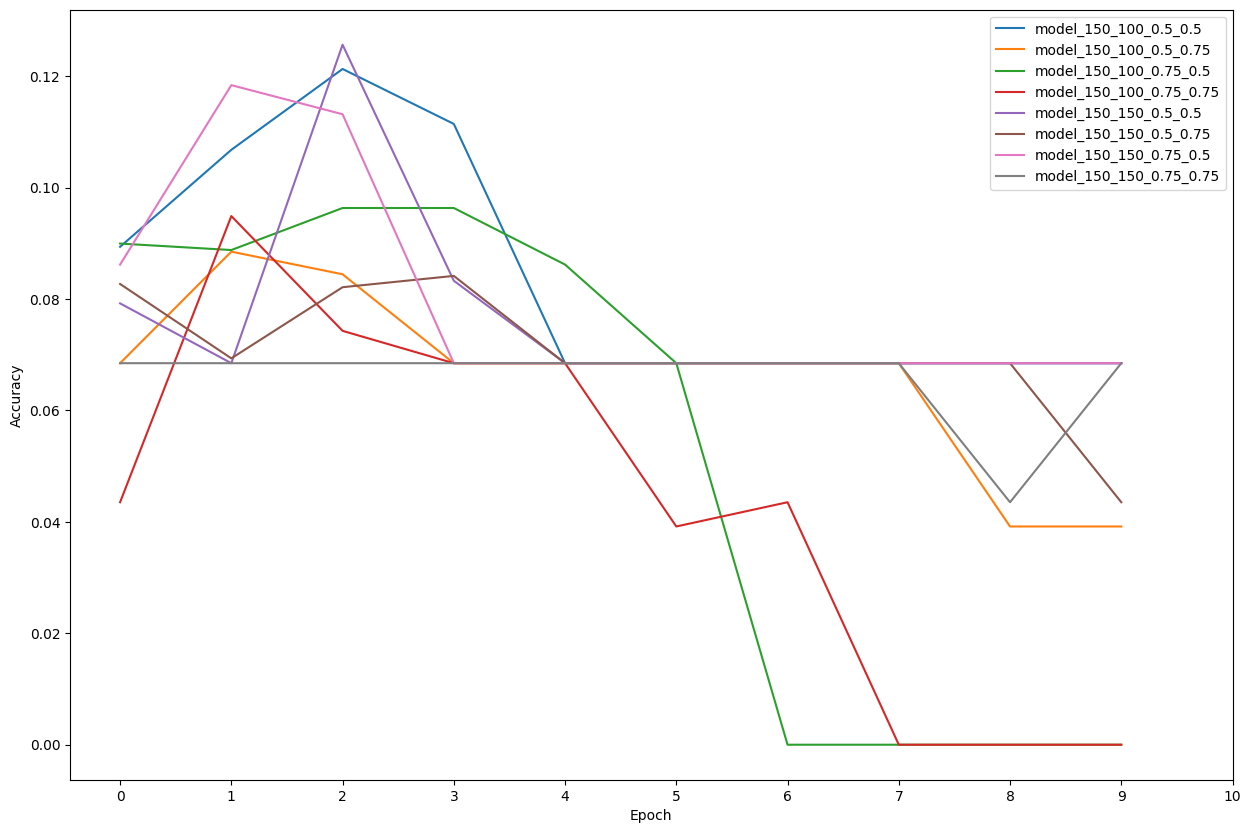

In [17]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(15,10))

#plt.plot(nofeat_trained_model.history['accuracy'], label='Train Accuracy')
for hist_key in model_history['history'].keys():
  if 'model_150_' in hist_key:
    plt.plot(model_history['history'][hist_key].history['val_accuracy'], label=hist_key)

plt.xticks(range(0, 11, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()